---
title: Regridding Sentinel-3 SLSTR Data
subtitle: Learn how to regridding Sentinel-3 SLSTR data
authors:
  - name: Yuvraj Adagale
    orcid: 0009-0008-1259-3399
    github: Yuvraj198920
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
date: 2025-05-19
thumbnail: https://raw.githubusercontent.com/EOPF-Sample-Service/eopf-sample-notebooks/refs/heads/main/notebooks/static/ESA_logo_2020_Deep.png
keywords: ["earth observation", "remote sensing"]
tags: ["xarray", "Sentinel-3", "Climate-Change", "EOPF"]
releaseDate: 2025-01-29
datePublished: 2025-01-29
dateModified: 2025-06-10
github: https://github.com/EOPF-Sample-Service/eopf-sample-notebooks
license: Apache-2.0
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of contents

- [Introduction](#1-introduction)
  - [Objective](#11-objective)
  - [Questions](#12-questions)

- [Setup](#2-setup)
  - [Import Libraries](#21-import-libraries)

- [Data Loading](#3-data-loading)
  - [Load LST Data](#31-load-lst-data)
  - [Verify Data Extent](#32-verify-data-extent)

- [Regridding](#4-regridding)
  - [Define Target Grid](#41-define-target-grid)
  - [Apply Regridding with GridData](#42-apply-regridding-with-griddata)

- [Visualization](#5-visualization)
  - [Plot Regridded Data](#51-plot-regridded-data)
  - [Plot Original Data](#52-optional-plot-original-data)

- [Display Statistics](#display-statistics)
  - [Statistics for original and regridded Netherlands data](#statistics-for-original-and-regridded-netherlands-data)
  - [Statistics for original and regridded full data](#statistics-for-original-and-regridded-full-data)



# 1. Introduction  
We’ll take a Sentinel-3 dataset—specifically, the Sea and Land Surface Temperature Radiometer (SLSTR) Level-2 Land Surface Temperature (LST) product—and show how regridding transforms it from its original irregular grid to a uniform grid. This will help illustrate why regridding is useful and what changes it introduces.

**What is Regridding?**

Regridding is the process of converting spatial data from its original grid (e.g., the irregular swath pattern of a satellite) to a regular grid with consistent spatial resolution. This makes the data easier to analyze, visualize, and integrate with other datasets.  

### Objectives
- [Understand the structure of Sentinel-3 SLSTR LST data.](https://sentiwiki.copernicus.eu/web/slstr-products#S3-SLSTR-Products-L2-LST-Products)
- Learn how to regrid irregular swath data into a uniform grid.
- Visualize the regridded data alongside the original data for comparison.

### Questions
- What are the benefits of regridding satellite data?
- How does the regridding process affect the data quality and resolution?


## Prerequisites
Ensure the following libraries are installed: xarray, matplotlib, cartopy, numpy, scipy

Install via: pip install xarray matplotlib cartopy numpy scipy

(Setup)=
## Setup
### Import Libraries

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy.interpolate import griddata

# Data Loading
### Load LST Data
Replace with your actual file path

In [16]:
# Replace with your actual file path
file_path = "https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S3A_SL_2_LST____20230601T093633_20230601T093933_20230602T185038_0179_099_250_1980_PS1_O_NT_004.zarr"
dt = xr.open_datatree(file_path, engine="zarr", consolidated=True)
measurements_ds = dt["measurements"].ds

# Extract variables
lst_original = measurements_ds["lst"]  # Land Surface Temperature
lat_original = measurements_ds["latitude"]
lon_original = measurements_ds["longitude"]

### Verify Data Extent

In [17]:
lat_min, lat_max = lat_original.min().item(), lat_original.max().item()
lon_min, lon_max = lon_original.min().item(), lon_original.max().item()
lat_min, lat_max, lon_min, lon_max

(49.378370999999994, 62.922801, 1.648556, 30.086996)

# Regridding


### Define Target Grid

In [30]:
target_resolution = 0.02

# Compute number of points based on extent and resolution for full extent
n_points_lat_full = int(np.ceil((lat_max - lat_min) / target_resolution)) + 1
n_points_lon_full = int(np.ceil((lon_max - lon_min) / target_resolution)) + 1
target_lat_full = np.linspace(lat_min, lat_max, n_points_lat_full)
target_lon_full = np.linspace(lon_min, lon_max, n_points_lon_full)
lon_grid_full, lat_grid_full = np.meshgrid(target_lon_full, target_lat_full)

### Apply Regridding with GridData

In [31]:
lst_regridded_full = griddata(
    (lon_original.values.flatten(), lat_original.values.flatten()),
    lst_original.values.flatten(),
    (lon_grid_full, lat_grid_full),
    method="linear",
)
print("Regridding completed.")
print(
    f"Regridded LST (Full Extent) shape: {lst_regridded_full.shape} (lat points: {n_points_lat_full}, lon points: {n_points_lon_full})"
)

Regridding completed.
Regridded LST (Full Extent) shape: (679, 1423) (lat points: 679, lon points: 1423)


# Visualization

### Plot Regridded Data

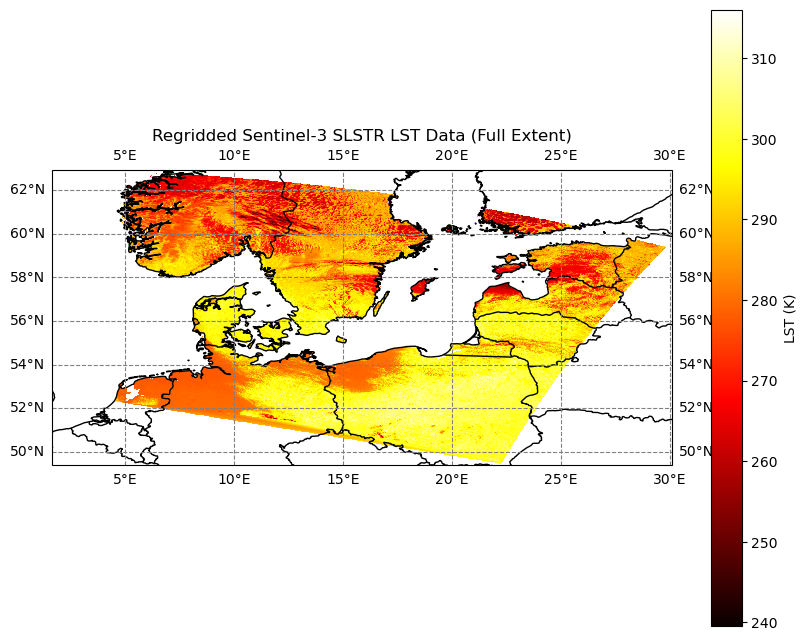

In [32]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})
mappable = ax.pcolormesh(lon_grid_full, lat_grid_full, lst_regridded_full, cmap="hot")
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title("Regridded Sentinel-3 SLSTR LST Data (Full Extent)")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
plt.colorbar(mappable, ax=ax, label="LST (K)")
ax.gridlines(draw_labels=True, color="gray", linestyle="--")
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
plt.show()

### (Optional) Plot Original Data

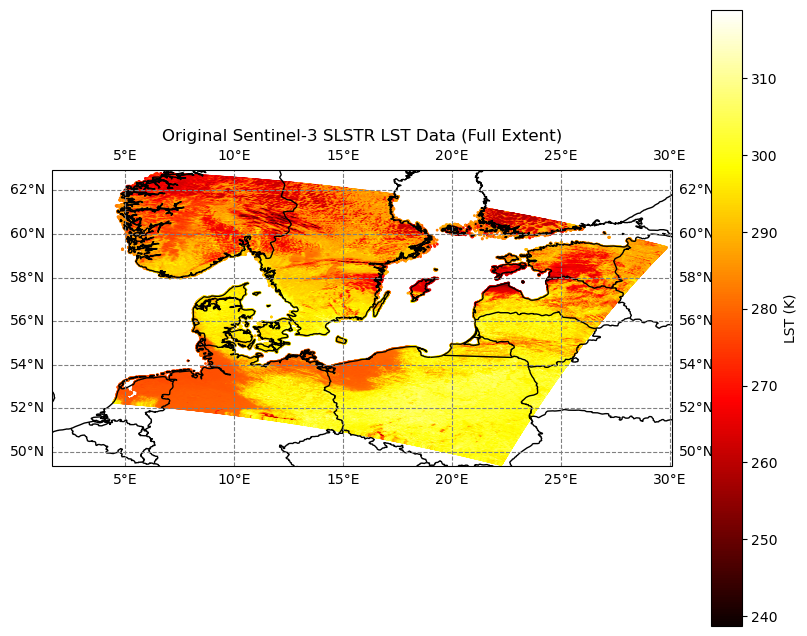

In [33]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})
scatter = ax.scatter(lon_original, lat_original, c=lst_original, cmap="hot", s=1)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title("Original Sentinel-3 SLSTR LST Data (Full Extent)")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
plt.colorbar(scatter, ax=ax, label="LST (K)")
ax.gridlines(draw_labels=True, color="gray", linestyle="--")
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
plt.show()

### Define Netherlands-specific grid (approx. 50.75–53.5°N, 3.2–7.2°E)

In [36]:
# Define Netherlands subset (50.75–53.5°N, 3.2–7.2°E)
mask_nl = (
    (lat_original >= 50.75)
    & (lat_original <= 53.5)
    & (lon_original >= 3.2)
    & (lon_original <= 7.2)
)
lst_original_nl = lst_original.where(mask_nl, drop=True)
lat_original_nl = lat_original.where(mask_nl, drop=True)
lon_original_nl = lon_original.where(mask_nl, drop=True)

In [37]:
# Compute number of points for Netherlands
lat_min_nl, lat_max_nl = 50.75, 53.5
lon_min_nl, lon_max_nl = 3.2, 7.2
n_points_lat_nl = int(np.ceil((lat_max_nl - lat_min_nl) / target_resolution)) + 1
n_points_lon_nl = int(np.ceil((lon_max_nl - lon_min_nl) / target_resolution)) + 1
target_lat_nl = np.linspace(lat_min_nl, lat_max_nl, n_points_lat_nl)
target_lon_nl = np.linspace(lon_min_nl, lon_max_nl, n_points_lon_nl)
lon_grid_nl, lat_grid_nl = np.meshgrid(target_lon_nl, target_lat_nl)

### Regrid for Netherlands Grid

In [38]:
lst_regridded_nl = griddata(
    (lon_original.values.flatten(), lat_original.values.flatten()),
    lst_original.values.flatten(),
    (lon_grid_nl, lat_grid_nl),
    method="linear",
)

In [39]:
print("Regridding completed.")
print(
    f"Regridded LST (Full Extent) shape: {lst_regridded_full.shape} (lat points: {n_points_lat_full}, lon points: {n_points_lon_full})"
)
print(
    f"Regridded LST (Netherlands) shape: {lst_regridded_nl.shape} (lat points: {n_points_lat_nl}, lon points: {n_points_lon_nl})"
)

# 4.3 Display Statistics
# Statistics for original Netherlands data
if lst_original_nl is not None and not lst_original_nl.isnull().all():
    mean_orig_nl = lst_original_nl.mean().item()
    std_orig_nl = lst_original_nl.std().item()
else:
    mean_orig_nl = float("nan")
    std_orig_nl = float("nan")
    print("Warning: No valid data in original Netherlands subset.")

# Statistics for regridded Netherlands data
if lst_regridded_nl is not None and not np.isnan(lst_regridded_nl).all():
    mean_regridded_nl = np.nanmean(lst_regridded_nl)
    std_regridded_nl = np.nanstd(lst_regridded_nl)
else:
    mean_regridded_nl = float("nan")
    std_regridded_nl = float("nan")
    print("Warning: No valid data in regridded Netherlands data.")

Regridding completed.
Regridded LST (Full Extent) shape: (679, 1423) (lat points: 679, lon points: 1423)
Regridded LST (Netherlands) shape: (139, 201) (lat points: 139, lon points: 201)


### Visualization (Netherlands Side-by-Side)

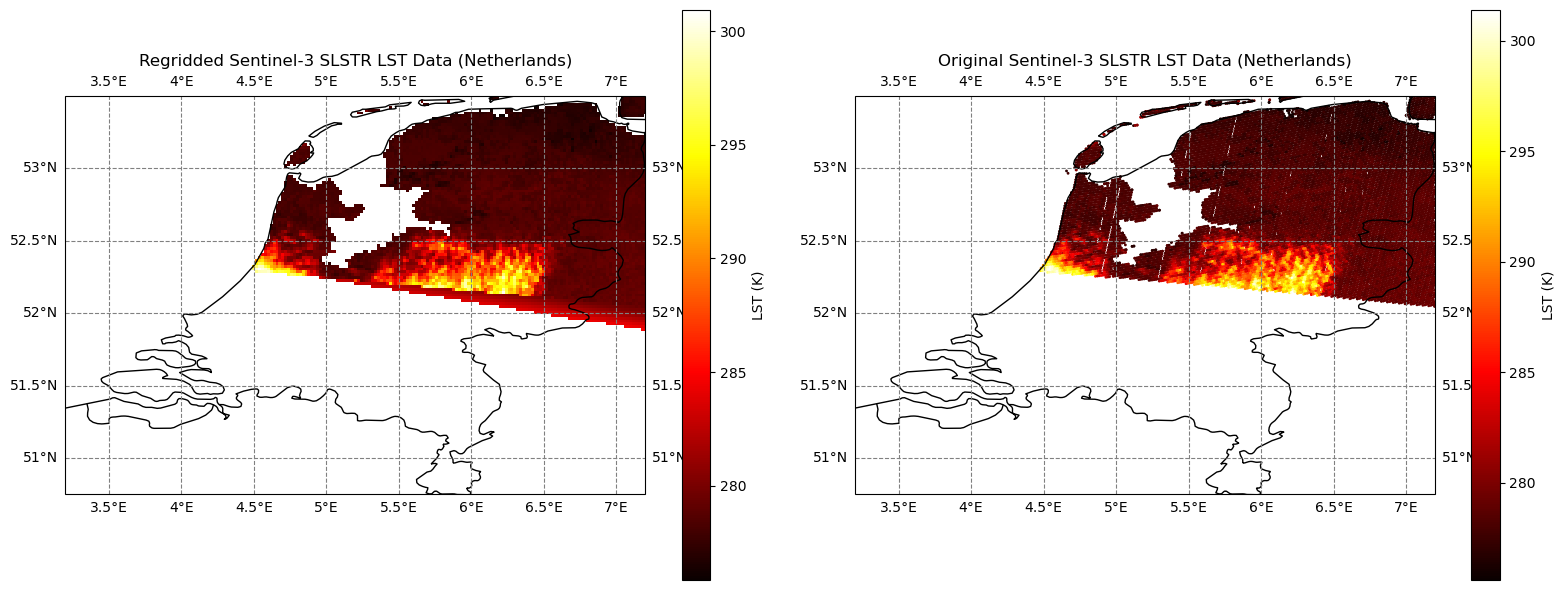

In [45]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 6), subplot_kw={"projection": ccrs.PlateCarree()}
)

# 5.2.1 Plot Regridded Data (Netherlands)
mappable1 = ax1.pcolormesh(lon_grid_nl, lat_grid_nl, lst_regridded_nl, cmap="hot")
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS)
ax1.set_title("Regridded Sentinel-3 SLSTR LST Data (Netherlands)")
ax1.set_xlabel("Longitude (°E)")
ax1.set_ylabel("Latitude (°N)")
plt.colorbar(mappable1, ax=ax1, label="LST (K)")
ax1.gridlines(draw_labels=True, color="gray", linestyle="--")
ax1.set_xlim(lon_min_nl, lon_max_nl)
ax1.set_ylim(lat_min_nl, lat_max_nl)

# 5.2.2 Plot Original Data (Netherlands)
scatter2 = ax2.scatter(
    lon_original_nl, lat_original_nl, c=lst_original_nl, cmap="hot", s=1
)
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS)
ax2.set_title("Original Sentinel-3 SLSTR LST Data (Netherlands)")
ax2.set_xlabel("Longitude (°E)")
ax2.set_ylabel("Latitude (°N)")
plt.colorbar(scatter2, ax=ax2, label="LST (K)")
ax2.gridlines(draw_labels=True, color="gray", linestyle="--")
ax2.set_xlim(lon_min_nl, lon_max_nl)
ax2.set_ylim(lat_min_nl, lat_max_nl)

plt.tight_layout()
plt.show()

# Display Statistics
### Statistics for original and regridded Netherlands data

In [43]:
if lst_original_nl is not None and not lst_original_nl.isnull().all():
    mean_orig_nl = lst_original_nl.mean().item()
    std_orig_nl = lst_original_nl.std().item()
else:
    mean_orig_nl = float("nan")
    std_orig_nl = float("nan")
    print("Warning: No valid data in original Netherlands subset.")

# Statistics for regridded Netherlands data
if lst_regridded_nl is not None and not np.isnan(lst_regridded_nl).all():
    mean_regridded_nl = np.nanmean(lst_regridded_nl)
    std_regridded_nl = np.nanstd(lst_regridded_nl)
else:
    mean_regridded_nl = float("nan")
    std_regridded_nl = float("nan")
    print("Warning: No valid data in regridded Netherlands data.")

print("\nNetherlands LST Statistics:")
print(f"Original Mean: {mean_orig_nl:.2f} K")
print(f"Original Std Dev: {std_orig_nl:.2f} K")
print(f"Regridded Mean: {mean_regridded_nl:.2f} K")
print(f"Regridded Std Dev: {std_regridded_nl:.2f} K")
print(f"Mean Difference: {(mean_regridded_nl - mean_orig_nl):.2f} K")
print(f"Std Dev Difference: {(std_regridded_nl - std_orig_nl):.2f} K")


Netherlands LST Statistics:
Original Mean: 279.78 K
Original Std Dev: 3.90 K
Regridded Mean: 280.01 K
Regridded Std Dev: 3.85 K
Mean Difference: 0.24 K
Std Dev Difference: -0.05 K


### Statistics for original and regridded full data

In [44]:
if lst_original is not None and not lst_original.isnull().all():
    mean_orig = lst_original.mean().item()
    std_orig = lst_original.std().item()
else:
    mean_orig = float("nan")
    std_orig = float("nan")
    print("Warning: No valid data in original subset.")

# Statistics for regridded  data
if lst_regridded_full is not None and not np.isnan(lst_regridded_full).all():
    mean_regridded = np.nanmean(lst_regridded_full)
    std_regridded = np.nanstd(lst_regridded_full)
else:
    mean_regridded = float("nan")
    std_regridded = float("nan")
    print("Warning: No valid data in regridded  data.")

print("Full area LST Statistics:")
print(f"Original Mean: {mean_orig:.2f} K")
print(f"Original Std Dev: {std_orig:.2f} K")
print(f"Regridded Mean: {mean_regridded:.2f} K")
print(f"Regridded Std Dev: {std_regridded:.2f} K")
print(f"Mean Difference: {(mean_regridded - mean_orig):.2f} K")
print(f"Std Dev Difference: {(std_regridded - std_orig):.2f} K")

Full area LST Statistics:
Original Mean: 288.87 K
Original Std Dev: 11.77 K
Regridded Mean: 288.46 K
Regridded Std Dev: 11.65 K
Mean Difference: -0.41 K
Std Dev Difference: -0.13 K


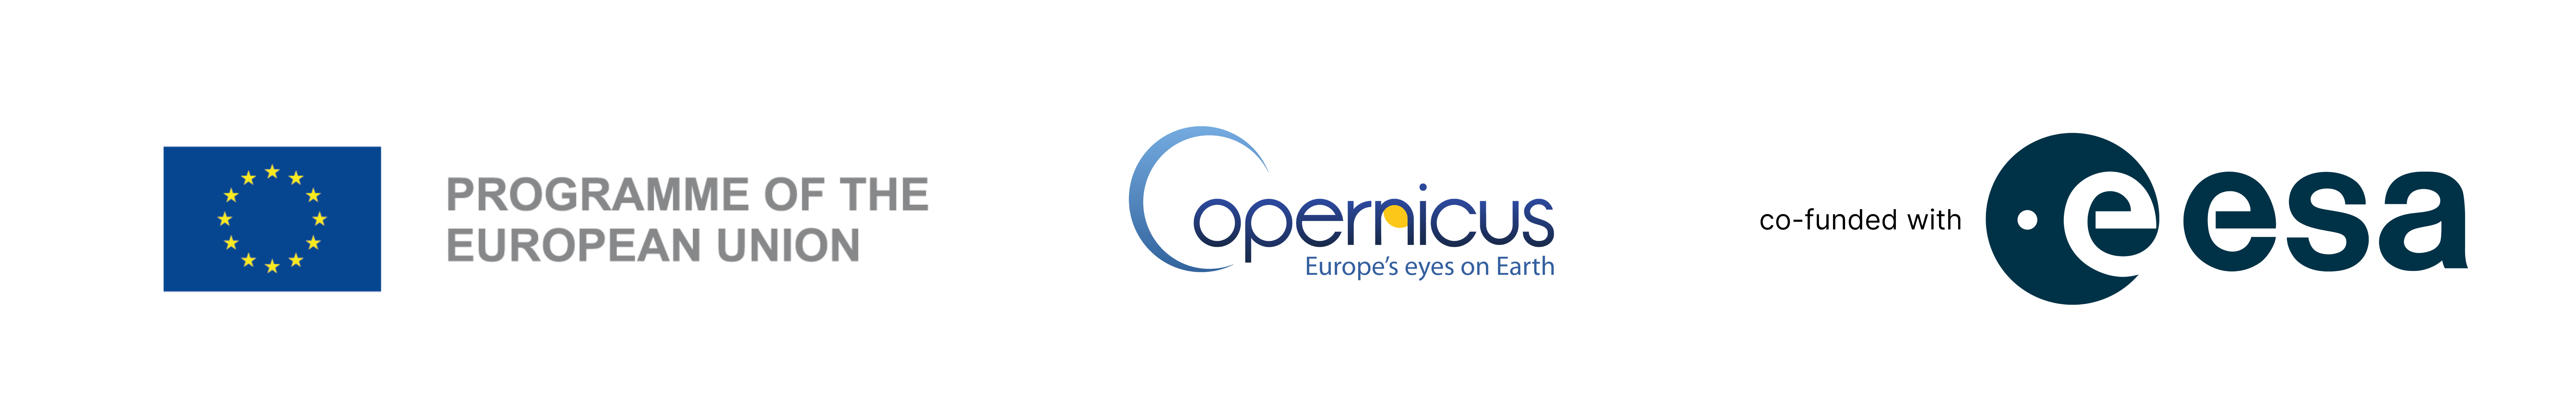